# This notebook examines general trends in FAC data
A more thorough writeup can be found in https://drive.google.com/open?id=1U6stzP7qhqB3B10kNYnWdlgtAibwoFEI6cuKOSSq-ZU

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import os
import re

processed_path = '/data/ihwang/data_journalism/allfac/processed/'
df_general = pd.read_pickle(processed_path + 'general.pkl')
# print('General DF\n', df_general.head())

# Agency prefix dictionary:
with open(processed_path + 'agency_dict.pkl', 'rb') as f_r:
    agency_dict = pickle.load(f_r)
# Entity code dictionary:
with open(processed_path + 'entity_dict.pkl', 'rb') as f_r:
    entity_dict = pickle.load(f_r)

## Follow the money!

What are the all-time largest amounts of federal money granted?

In [23]:
df_general.groupby(['AUDITYEAR', 'DBKEY'])['TOTFEDEXPEND'].sum().sort_values(ascending=False).head(10)

AUDITYEAR  DBKEY 
2017       183033    241863115093
2005       72985     158045100000
2010       131803    120675950932
2009       131803    107589903039
2017       131803     98428435775
2016       131803     93382292194
2011       131803     90846260543
2015       131803     90427072727
2008       131803     87389490908
2007       131803     76655553902
Name: TOTFEDEXPEND, dtype: int64

In [26]:
df_general[(df_general['AUDITYEAR'] == 2010) & (df_general['DBKEY']==131803)]

,DBKEY,AUDITYEAR,STATE,CPASTATE,CPAPHONE,TYPEOFENTITY,OVERSIGHTAGENCY,TOTFEDEXPEND,AUDITEENAME,CPAFIRMNAME,...,TYPEREPORT_MP,REPORTABLECONDITION,MATERIALWEAKNESS,MATERIALNONCOMPLIANCE,REPORTABLECONDITION_MP,MATERIALWEAKNESS_MP,QCOSTS,CITY,CPACITY,EIN
70187,131803,2010,CA,CA,9164450255,000,,120675950932,STATE OF CALIFORNIA,CALIFORNIA STATE AUDITOR,...,Q,Y,N,N,Y,Y,Y,SACRAMENTO,SACRAMENTO,680284175


Which entities have received the most money over time?

In [39]:
top_entity_agg = df_general.groupby('DBKEY')['TOTFEDEXPEND'].sum().sort_values(ascending=False).head(50)
print('Dollars', '\t', 'Entity name')
for entity in top_entity_agg.index:
    print(top_entity_agg.loc[entity], '\t', list(df_general[df_general['DBKEY'] == entity]['AUDITEENAME'])[0])

Dollars 	 Entity name
1615080026228 	 CALIFORNIA STATE REPORT
1005502746806 	 STATE OF NEW YORK
784226896403 	 TEXAS STATE REPORT
710629004723 	 PENNSYLVANIA HIGHER EDUCATION ASSISTANCE AGENCY
541569350019 	 FLORIDA STATE REPORT
450026524000 	 COMMONWEALTH OF PENNSYLVANIA
437336092584 	 STATE OF ILLINOIS BUREAU OF THE BUDGET
398825159230 	 STATE OF OHIO
395009444000 	 THE CITY OF NEW YORK
333875135414 	 STATE OF GEORGIA
331553820594 	 STATE OF NORTH CAROLINA
321400163911 	 STATE OF NEW JERSEY
294940377852 	 STATE OF TENNESSEE
294783815777 	 TEXAS GUARANTEED STUDENT LOAN CORPORATION
266291020793 	 LOUISIANA STATE REPORT
259568266364 	 COMMONWEALTH OF MASSACHUSETTS
249049046806 	 STATE OF WASHINGTON
247572435031 	 ARKANSAS STUDENT LOAN AUTHORITY
218877117520 	 STATE OF ARIZONA
211383037134 	 STATE OF WISCONSIN
198224815906 	 VIRGINIA STATE REPORT
196604950077 	 STATE OF MISSOURI
195150485280 	 JOHNS HOPKINS UNIVERSITY
190202629934 	 MARYLAND STATE
189756240056 	 STATE OF INDIANA
18224182

## Check percent of all audits by entity class and type

What is the percent of audits by entity class?

In [40]:
series_entities = df_general['TYPEOFENTITY'].value_counts().sort_values(ascending=False)
entity_class_dict = {}
for entity in series_entities.index:
    num_audits = series_entities.loc[entity]
    entity_class = entity[0]
    if entity_class not in entity_class_dict.keys():
        entity_class_dict[entity_class] = 0
    entity_class_dict[entity_class] += num_audits

for (entity_class, num_audits) in entity_class_dict.items():
    entity_keys = [i for i in entity_dict.keys() if i[0] == entity_class]
    entity_names = [entity_dict[i] for i in entity_keys]
    if len(entity_names) == 2:
        entity_class_name = '/'.join(entity_names)
    else:
        entity_class_name = os.path.commonprefix(entity_names)
    print((num_audits / len(df_general)) * 100, '\t', '%s**: %s' %(entity_class, entity_class_name))

44.0877481607 	 9**: Non-profit 
17.3550524506 	 5**: Independent Education Agency- Institution of Higher Education/Independent Local Education Agency (LEA)
15.2916249611 	  **: 
6.5783681314 	 2**: Municipality-
5.20366444489 	 1**: County-
5.26510438228 	 4**: Independent Special District 
2.58071597212 	 8**: For profit or outside U.S./UNKNOWN
0.971108913324 	 3**: Township-
1.29715813447 	 6**: Indian Tribe
1.2154370527 	 0**: State-
0.15401739645 	 7**: Territory


Now plot percent of audits by entity type

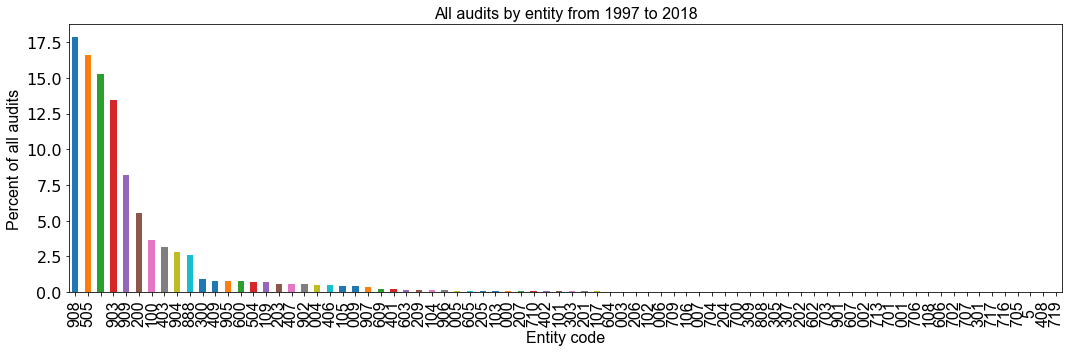

Total number of audits: 838217


In [3]:
fig, axes = plt.subplots(figsize=(15, 5))
series_entity_groups = df_general.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = series_entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('Entity code', fontsize=16, fontname='Arial')
percent_audits_plot.set_xticklabels(labels=series_entity_groups.index, fontsize=16, fontname='Arial')
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16, fontname='Arial')
percent_audits_plot.set_title(
    'All audits by entity from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

How does number of audits compare to total federal expenditure?

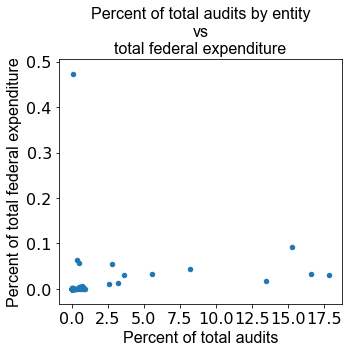

In [69]:
fig, axes = plt.subplots(figsize=(5, 5))
series_entity_groups = df_general.groupby('TYPEOFENTITY').size().sort_values(ascending=False) / len(df_general) * 100
series_entity_expenditures = df_general.groupby('TYPEOFENTITY')['TOTFEDEXPEND'].sum().sort_values(ascending=False) / df_general['TOTFEDEXPEND'].sum()
df_entities_expenditures = pd.concat(
    [series_entity_groups.rename('PCT_ENTITY'), series_entity_expenditures.rename('PCT_TOTFEDEXPEND')], 
    axis=1, sort=True
)
entities_expenditures_plot = df_entities_expenditures.plot(
    x='PCT_ENTITY', y='PCT_TOTFEDEXPEND', kind='scatter', fontsize=16, ax=axes
)
entities_expenditures_plot.set_xlabel('Percent of total audits', fontsize=16, fontname='Arial')
entities_expenditures_plot.set_ylabel('Percent of total federal expenditure', fontsize=16, fontname='Arial')
entities_expenditures_plot.set_title(
    'Percent of total audits by entity\nvs\ntotal federal expenditure', fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()

In [64]:
df_entities_expenditures.sort_values('PCT_TOTFEDEXPEND', ascending=False)

,PCT_ENTITY,PCT_TOTFEDEXPEND
000,0.096753,4.722514e-01
,15.291625,9.208779e-02
009,0.394886,6.460457e-02
004,0.528741,5.597866e-02
904,2.809416,5.543298e-02
909,8.182368,4.472859e-02
505,16.618608,3.390936e-02
200,5.540689,3.228388e-02
908,17.850390,3.130222e-02
100,3.634739,2.972675e-02


## Plot percent of all audits by state

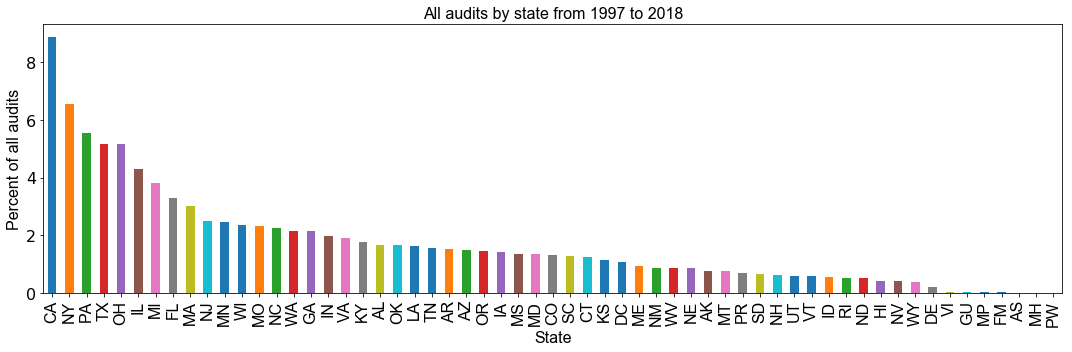

Total number of audits: 838217


In [4]:
fig, axes = plt.subplots(figsize=(15, 5))
series_entity_groups = df_general.groupby('STATE').size().sort_values(ascending=False) / len(df_general) * 100
percent_audits_plot = series_entity_groups.plot(kind='bar', fontsize=16)
percent_audits_plot.set_xlabel('State', fontsize=16, fontname='Arial')
percent_audits_plot.set_xticklabels(labels=series_entity_groups.index, fontsize=16, fontname='Arial')
percent_audits_plot.set_ylabel('Percent of all audits', fontsize=16, fontname='Arial')
percent_audits_plot.set_title(
    'All audits by state from %s to %s' %(min(df_general['AUDITYEAR']), max(df_general['AUDITYEAR'])),
    fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()
print('Total number of audits:', len(df_general))

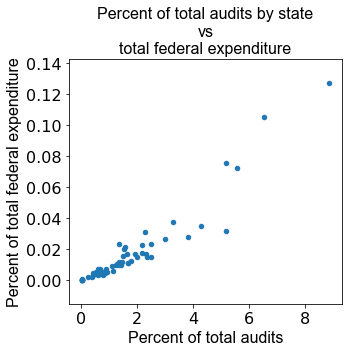

In [70]:
fig, axes = plt.subplots(figsize=(5, 5))
series_state_groups = df_general.groupby('STATE').size().sort_values(ascending=False) / len(df_general) * 100
series_state_expenditures = df_general.groupby('STATE')['TOTFEDEXPEND'].sum().sort_values(ascending=False) / df_general['TOTFEDEXPEND'].sum()
df_entities_expenditures = pd.concat(
    [series_state_groups.rename('PCT_STATE'), series_state_expenditures.rename('PCT_TOTFEDEXPEND')], 
    axis=1, sort=True
)
entities_expenditures_plot = df_entities_expenditures.plot(
    x='PCT_STATE', y='PCT_TOTFEDEXPEND', kind='scatter', fontsize=16, ax=axes
)
entities_expenditures_plot.set_xlabel('Percent of total audits', fontsize=16, fontname='Arial')
entities_expenditures_plot.set_ylabel('Percent of total federal expenditure', fontsize=16, fontname='Arial')
entities_expenditures_plot.set_title(
    'Percent of total audits by state\nvs\ntotal federal expenditure', fontsize=16, fontname='Arial'
)
plt.tight_layout()
plt.show()

## Combining entity type and state

Get top 10 entity types with the most audits, and within each entity type get top states with the most audits

In [74]:
series_top_entities = df_general['TYPEOFENTITY'].value_counts().head(10)
for (entity, num_audits) in zip(series_top_entities.index, series_top_entities):
    if entity in entity_dict.keys():
        entity_name = entity_dict[entity]
    else:
        entity_name = 'Agency not in dictionary'
    print(num_audits, '\t', entity_name)
    df_entity_states = df_general[df_general['TYPEOFENTITY']==entity]
    series_top_states = df_entity_states['STATE'].value_counts().head(10)
    for (state, num_audits) in zip(series_top_states.index, series_top_states):
        total_exp = df_general[
            (df_general['TYPEOFENTITY'] == entity) & (df_general['STATE'] == state)
        ]['TOTFEDEXPEND'].sum()
        print('\t', num_audits, '\t', total_exp, '\t', state)

149625 	 Non-profit Social Services Organization
	 15940 	 91456673831 	 CA
	 12282 	 70131114680 	 NY
	 10445 	 42814040616 	 PA
	 8040 	 45438874303 	 FL
	 7217 	 33936626852 	 TX
	 6917 	 28123203226 	 IL
	 6334 	 23748725342 	 OH
	 6008 	 30861156457 	 MA
	 4415 	 16001594242 	 MI
	 3501 	 10899932840 	 WI
139300 	 Independent Local Education Agency (LEA)
	 11230 	 111134620185 	 CA
	 11229 	 85252643995 	 TX
	 9851 	 21927402842 	 NY
	 9788 	 27665369909 	 OH
	 9294 	 39249892911 	 IL
	 8816 	 35458174218 	 PA
	 8320 	 35023467889 	 MI
	 4941 	 12252936410 	 NJ
	 4927 	 14271673529 	 MO
	 4823 	 16410017162 	 WI
128177 	 Agency not in dictionary
	 11276 	 340163891274 	 CA
	 8116 	 192354233162 	 NY
	 7612 	 113463655813 	 PA
	 6661 	 102015858750 	 TX
	 5992 	 60212970132 	 OH
	 5222 	 55844393715 	 IL
	 5090 	 46899552943 	 MI
	 4020 	 55015976996 	 MA
	 3941 	 68807213326 	 FL
	 3287 	 45125487276 	 NJ
112964 	 Non-profit Housing Organization
	 10675 	 38459664152 	 CA
	 9810 	

Get top 10 states with the most audits, and within each state get top entity types with most of audits

In [75]:
series_top_states = df_general['STATE'].value_counts().head(10)
for (state, num_audits) in zip(series_top_states.index, series_top_states):
    print(num_audits, '\t', state)
    df_entity_states = df_general[df_general['STATE'] == state]
    series_top_entities = df_entity_states['TYPEOFENTITY'].value_counts().head(10)
    for (entity, num_audits) in zip(series_top_entities.index, series_top_entities):
        if entity in entity_dict.keys():
            entity_name = entity_dict[entity]
        else:
            entity_name = 'Agency not in dictionary'
        total_exp = df_general[
            (df_general['TYPEOFENTITY'] == entity) & (df_general['STATE'] == state)
        ]['TOTFEDEXPEND'].sum()
        print('\t', num_audits, '\t', total_exp, '\t', entity_name)

74292 	 CA
	 15940 	 91456673831 	 Non-profit Social Services Organization
	 11276 	 340163891274 	 Agency not in dictionary
	 11230 	 111134620185 	 Independent Local Education Agency (LEA)
	 10675 	 38459664152 	 Non-profit Housing Organization
	 6612 	 62863288600 	 Non-profit Other Organization
	 5113 	 58930776563 	 Municipality-General Purpose Government
	 2039 	 10207995685 	 UNKNOWN
	 1800 	 72089215053 	 Non-profit Institution for Higher Education
	 1330 	 30667606627 	 Independent Education Agency- Institution of Higher Education
	 1213 	 3494432906 	 Indian Tribe-Wide/Alaskan Native Village-Wide
54788 	 NY
	 12282 	 70131114680 	 Non-profit Social Services Organization
	 9851 	 21927402842 	 Independent Local Education Agency (LEA)
	 8407 	 40512236052 	 Non-profit Housing Organization
	 8116 	 192354233162 	 Agency not in dictionary
	 4891 	 241140789903 	 Non-profit Other Organization
	 2279 	 122613937399 	 Non-profit Institution for Higher Education
	 1665 	 350979173169

## "Worst of" findings for select fields
Can select particular year or use all data in order to get aggregate statistics. Each subplot is the "worst of" for the row and column values.
* Financial Statements (TYPEREPORT_FS) and Major Program Compliance (TYPEREPORT_MP): opinion = U, Q, A or D, but focus on Q, A and D since the U's are majority and the other fields are super minorities
* Questioned Costs (QCOSTS), Reportable Condition (REPORTABLECONDITION, REPORTABLECONDITION_MP), Material Noncompliance (MATERIALNONCOMPLIANCE), and Material Weakness (MATERIALWEAKNESS, MATERIALWEAKNESS_MP): finding = primarily Y or N

In [7]:
df_plot = df_general.copy(deep=True)
# df_plot = df_general[df_general['AUDITYEAR'] == 2018]

In [8]:
fields = ['TYPEREPORT_FS', 'QCOSTS', 'MATERIALWEAKNESS', 'MATERIALNONCOMPLIANCE']
# fields = ['TYPEREPORT_MP', 'REPORTABLECONDITION_MP', 'MATERIALWEAKNESS_MP']
sortbys = ['STATE', 'TYPEOFENTITY', 'OVERSIGHTAGENCY']
print('Possible field types:')
for field in fields:
    print('%s: %s' %(field, ', '.join(set(df_general[field]))))

Possible field types:
TYPEREPORT_FS: , UQD, D, 3, QD, UD, A, QAD, Q., QA, UQ, Q, AD, AQ, UAD, UQA, U, S, UA
QCOSTS: N, Y
MATERIALWEAKNESS: , N, 2, 3, y, x, X, 0, Y, n
MATERIALNONCOMPLIANCE: , N, Y


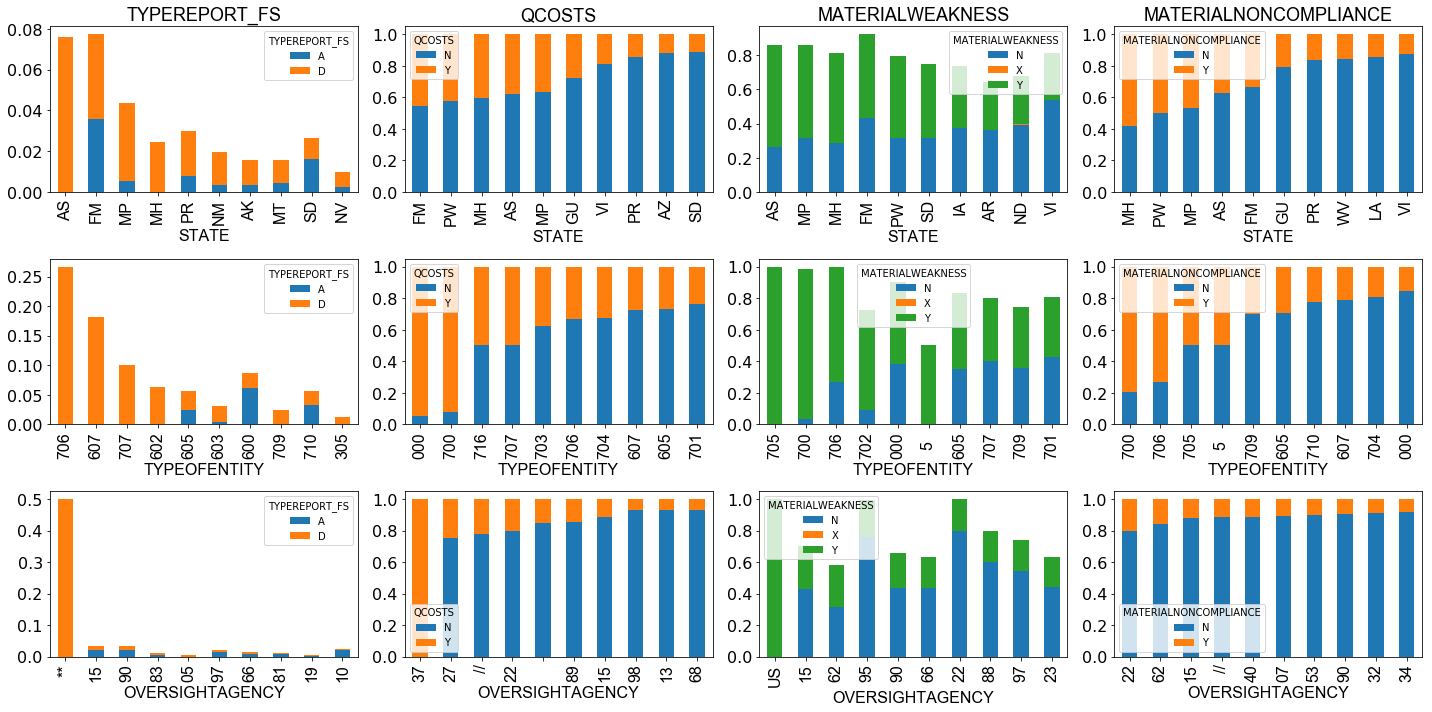

In [9]:
fig, axes = plt.subplots(nrows=len(sortbys), ncols=len(fields), figsize=(len(fields)*5, 10))
for (i, sortby) in enumerate(sortbys):
    for (j, field) in enumerate(fields):
        series_grouped = df_plot.groupby(sortby)[field].value_counts()
        df_grouped = series_grouped.unstack()
        df_grouped_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)
        if 'TYPEREPORT' in field:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['A', 'D']]
            ]
            top_sortby = df_select_fields.sort_values(['D', 'A'], ascending=False).head(10).index
        else:
            df_select_fields = df_grouped_normalized[
                [i for i in df_grouped_normalized.columns if i in ['Y', 'N', 'X']]
            ]
            top_sortby = df_select_fields['Y'].sort_values(ascending=False).head(10).index
        df_select_sorted = df_select_fields.reindex(index=top_sortby)
        plot_top_sorted = df_select_sorted.plot(
            kind='bar', fontsize=16, stacked=True, ax=axes[i, j]
        )
        if i == 0:
            plot_top_sorted.set_title(field, fontsize=18, fontname='Arial')
        plot_top_sorted.set_xticklabels(labels=df_select_sorted.index, fontsize=16, fontname='Arial')
        plot_top_sorted.set_xlabel(sortby, fontsize=16, fontname='Arial')
plt.tight_layout()
plt.show()